## Bitcoin Prediction
#### Model to predict the price of Bitcoin (BTC)
#### Machine Learning Algorithm: **XGBoost**, **LSTM**, **SVM**

## Import Libraries

In [25]:
import pandas as pd
import seaborn as sns

import json
import calendar

import joblib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import f1_score, classification_report, ConfusionMatrixDisplay, confusion_matrix, roc_curve, auc

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

## Visualise Dataset

In [26]:
data_df = pd.read_csv("../price-prediction/BTC-USD.csv")
data_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [27]:
def data_summary(df, message):
    ''' Returns a summary data in the df'''
    
    print(f'{message}:\n')
    print('Number of rows: ', df.shape[0])
    print("\nNumber of features:", df.shape[1])
    print("\nData Features:")
    print(df.columns.tolist())
    print("\nMissing values:", df.isnull().sum().values.sum())
    print("\nUnique values:")
    print(df.nunique())

In [28]:
data_summary(data_df, 'Overview of the dataset')

Overview of the dataset:

Number of rows:  2713

Number of features: 7

Data Features:
['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

Missing values: 0

Unique values:
Date         2713
Open         2709
High         2710
Low          2712
Close        2710
Adj Close    2710
Volume       2713
dtype: int64


In [29]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2713 entries, 0 to 2712
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2713 non-null   object 
 1   Open       2713 non-null   float64
 2   High       2713 non-null   float64
 3   Low        2713 non-null   float64
 4   Close      2713 non-null   float64
 5   Adj Close  2713 non-null   float64
 6   Volume     2713 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 148.5+ KB


#### Figure 1: Plot BTC Closing Price over time

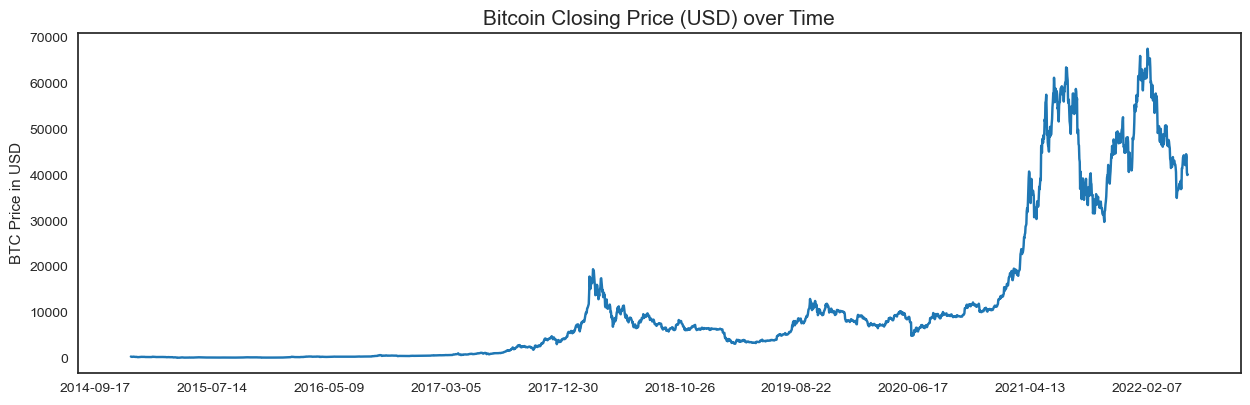

In [30]:
plt.style.use('seaborn-white')
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors)

plt.figure(figsize=(15, 5))

plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))
plt.gcf().autofmt_xdate(rotation=0)

plt.plot(data_df['Date'], data_df['Close'])
plt.title('Bitcoin Closing Price (USD) over Time', fontsize=15)
plt.ylabel('BTC Price in USD')
plt.show()

Check for any duplicate columns and remove these

In [31]:
data_df.T.duplicated()

Date         False
Open         False
High         False
Low          False
Close        False
Adj Close     True
Volume       False
dtype: bool

In [32]:
duplicated_cols = data_df.columns[data_df.T.duplicated()]
data_df = data_df.drop(columns=duplicated_cols, axis=1)

In [33]:
data_df.head()

,Date,Open,High,Low,Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100


In [34]:
#pd.DataFrame.drop?

#### Figure 2: Plot distribution for Open, High, Low and Close features

In [35]:
data_df.iloc[:, 1:].columns.tolist()

['Open', 'High', 'Low', 'Close', 'Volume']

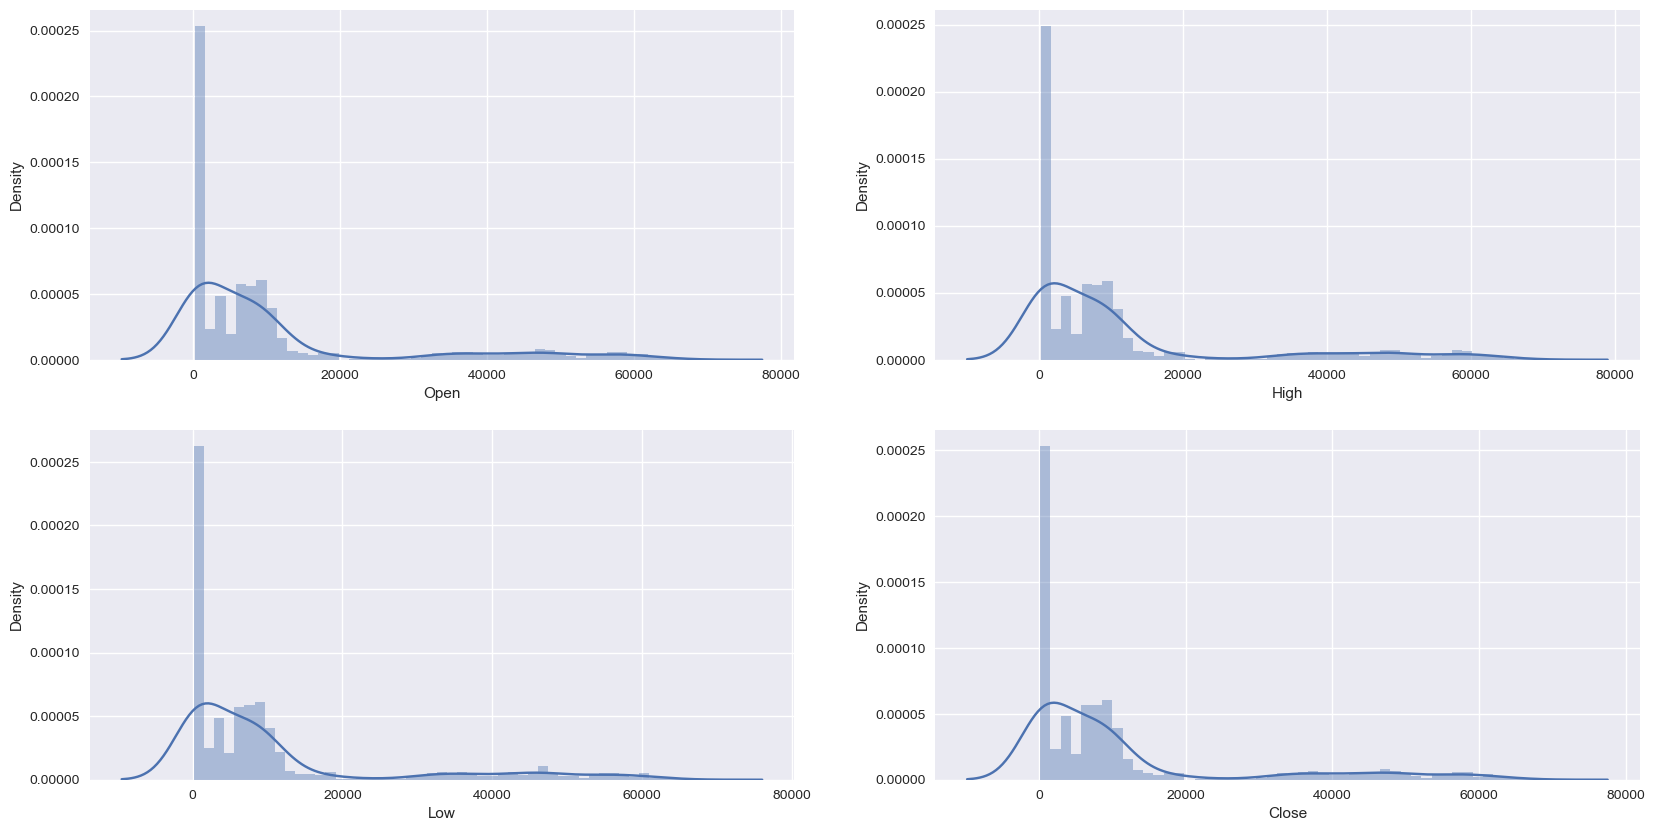

In [36]:
features = data_df.iloc[:, 1:-1].columns.tolist()
plt.style.use('seaborn')

plt.subplots(figsize=(20,10))
for i, col in enumerate(features):
    plt.subplot(2,2,i+1)
    sns.distplot(data_df[col])
plt.show()

#### Figure 3: Box Plot for Features to Understand the Outliers

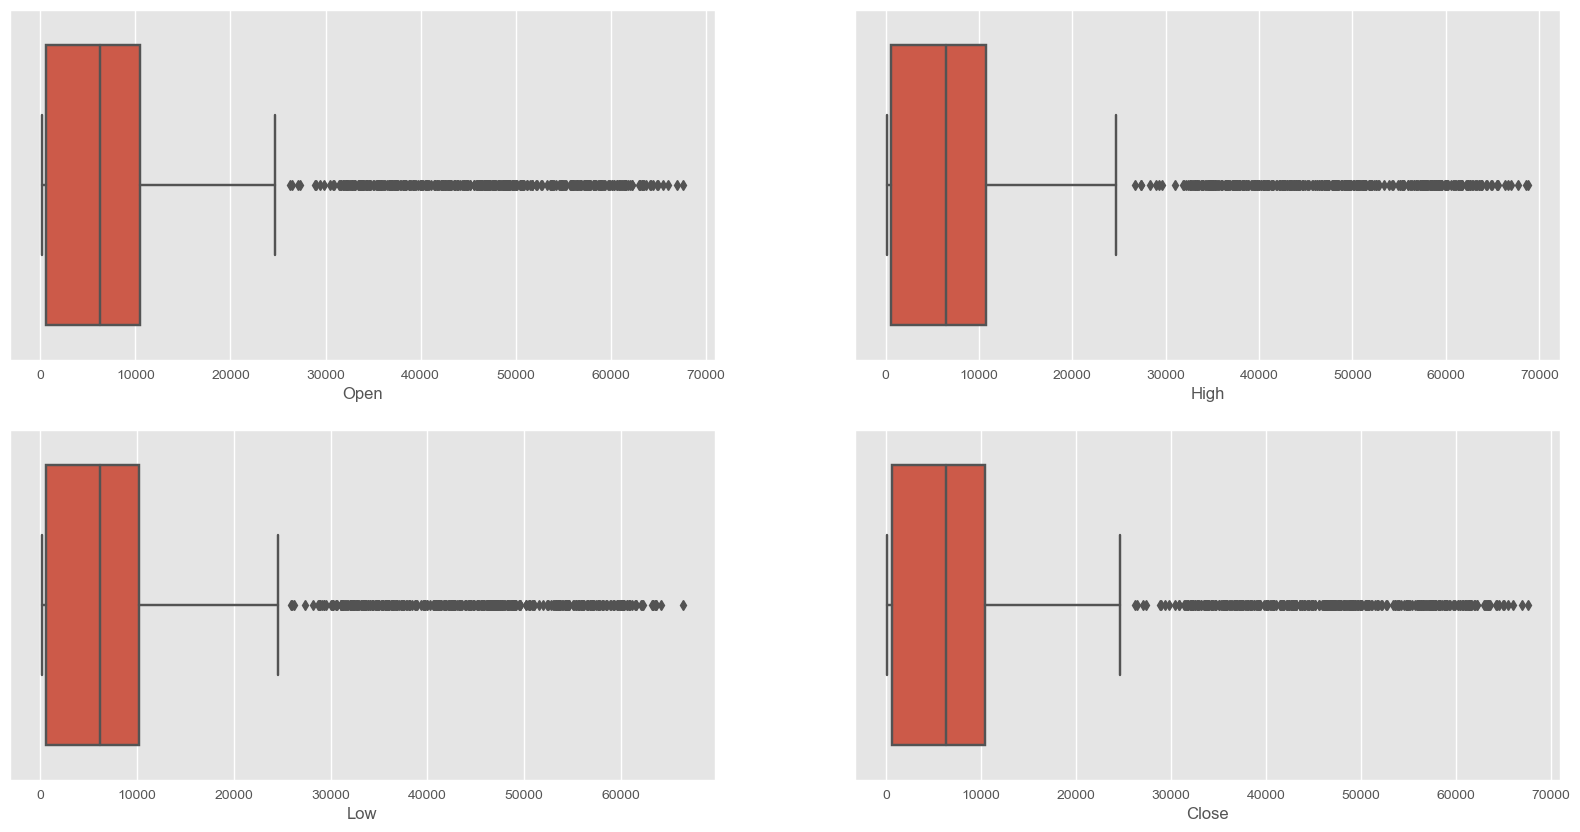

In [37]:
plt.subplots(figsize=(20,10))
plt.style.use('ggplot')
for i, col in enumerate(features):
    plt.subplot(2,2,i+1)
    sns.boxplot(data_df[col])
plt.show()

Many outliers present for all features (Open, High, Low and Close)

## Feature Enginering

Convert 'Date' column to date and create new features for date parts

In [38]:
data_df['Date'] = pd.to_datetime(data_df['Date'])
data_df['Year'] = data_df['Date'].dt.year
data_df['Month'] = data_df['Date'].dt.month
data_df['Day'] = data_df['Date'].dt.day

data_df.head()

,Date,Open,High,Low,Close,Volume,Year,Month,Day
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,2014,9,17
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,2014,9,18
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,2014,9,19
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,2014,9,20
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,2014,9,21


Group data by year and take the average

In [39]:
df_grouped = data_df.groupby('Year').mean()
df_grouped

,Open,High,Low,Close,Volume,Month,Day
Year,,,,,,,
2014,365.058217,373.265397,355.903726,363.693085,2.383690e+07,10.735849,16.849057
2015,272.149011,278.151978,266.807891,272.453381,3.390557e+07,6.526027,15.720548
2016,567.141429,574.302273,560.453374,568.492407,8.592451e+07,6.513661,15.756831
2017,3970.644848,4144.687445,3811.707792,4006.033629,2.382867e+09,6.526027,15.720548
2018,7601.018680,7787.978969,7350.747939,7572.298947,6.063552e+09,6.526027,15.720548
2019,7385.218456,7549.907409,7222.602868,7395.246282,1.673049e+10,6.526027,15.720548
2020,11056.787201,11304.359035,10844.595163,11116.378092,3.302327e+10,6.513661,15.756831
2021,47402.115663,48762.998925,45852.003082,47436.932021,4.715574e+10,6.526027,15.720548
2022,41468.636797,42225.196172,40415.898360,41345.687735,2.718684e+10,1.380000,13.720000


#### Figure 4: Bar Charts for Each Feature Average per Year

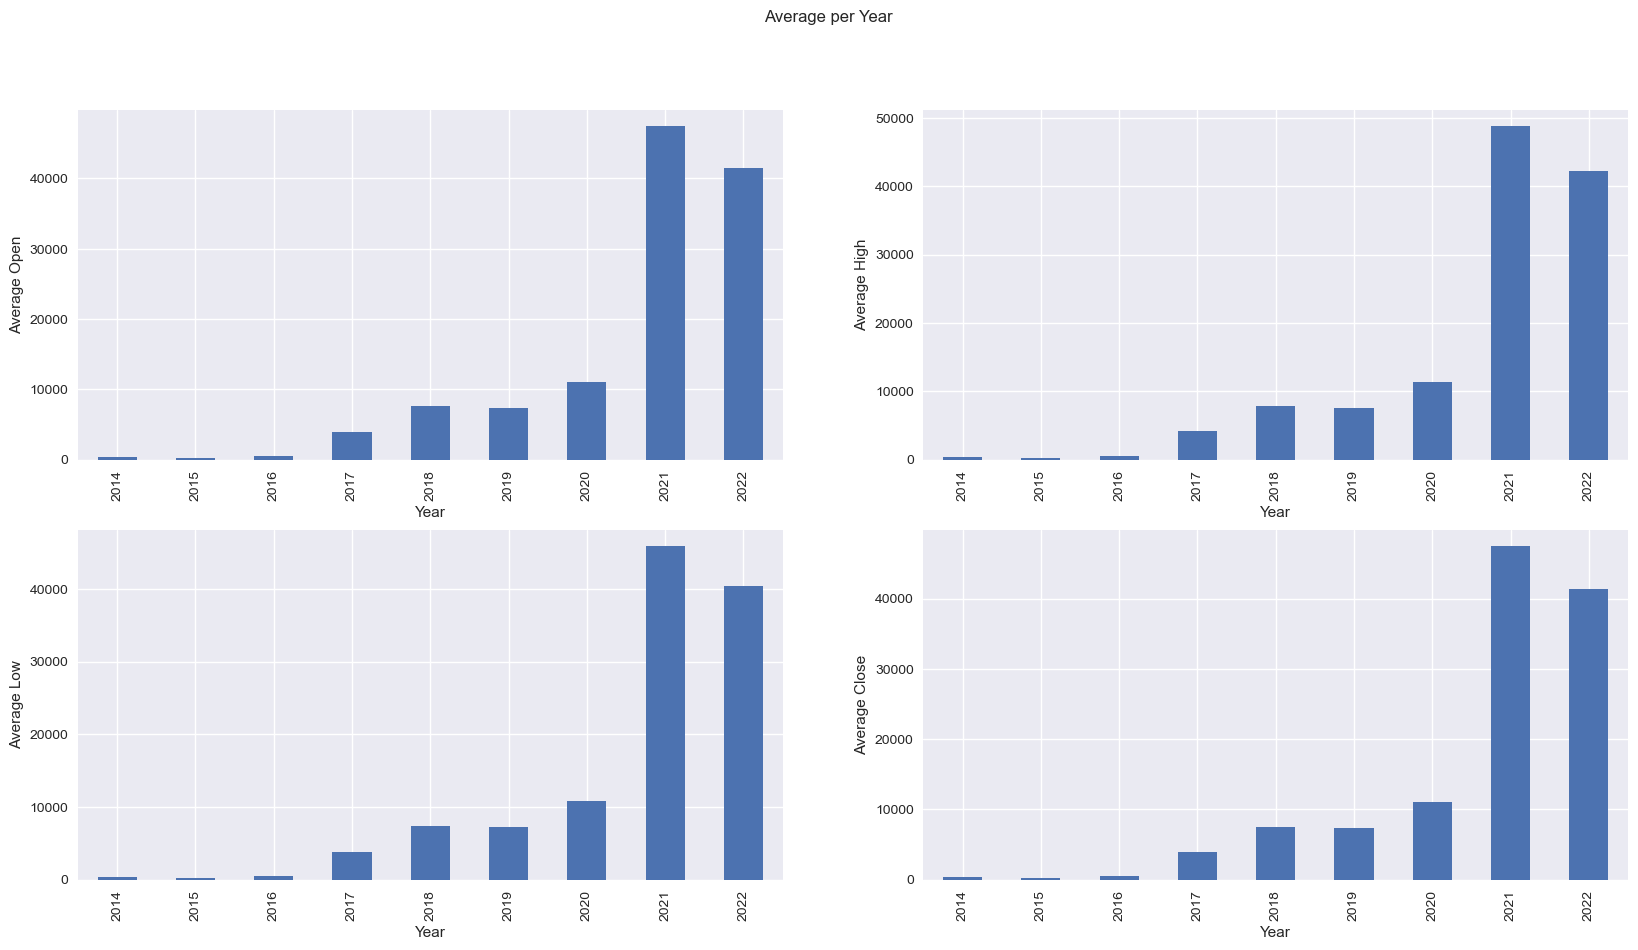

In [59]:
plt.subplots(figsize=(20,10))
plt.style.use('seaborn')

for position, feature in enumerate(features):
    
    ax = plt.subplot(2, 2, position+1)
    df_grouped[feature].plot.bar(ax=ax)
    ax.set_xlabel('Year') 
    ax.set_ylabel('Average '+ feature) 
plt.suptitle('Average per Year') 
plt.show()

Check if any of the numeric fields are correlated

In [ ]:
corr_matrix = data_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')